# Control of a solar home with Stochastic Dynamic Programming (SDP)

using the [stodynprog](https://github.com/pierre-haessig/stodynprog) package

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.stats as stats

In [3]:
from stodynprog import SysDescription, DPSolver

Import solarhome utility module

In [4]:
from pathlib import Path
p_utils = Path('../../utils')
assert(p_utils.exists())

import sys
sys.path.append(str(p_utils))

import benchutils
from benchutils import load_data, load_results

### Load testcase data

Test data

In [5]:
params, data = load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


Training data

In [6]:
params, data_train = load_data(subset='train')

In [7]:
n = len(data)
ndays = n//48 # days
ndays

30

Solar home parameters:

In [8]:
E_rated = params['E_rated'] # kWh
P_pvp = params['P_pvp'] # kW
print('E_rated: {:.1f} kWh'.format(E_rated))
print('P_pvp: {:.1f} kW'.format(P_pvp))

E_rated: 8.0 kWh
P_pvp: 4.0 kW


Battery power (unspecified in the base problem)

In [9]:
P_rated = 3 # kW

Extract time series of test data

In [10]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp;

t = data.index
dt = t[1] - t[0]
td = t/24 #days

In [11]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.70%


Extract time series of training data

In [12]:
P_load_train = data_train.P_load_sp
P_sun_train = data_train.P_sun_1k*P_pvp;

In [13]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun_train.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load_train.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun_train.mean()/P_load_train.mean()))

Average sun energy: 14.70 kWh/d
Average load      : 18.19 kWh/d
ratio sun/load: 80.82%


Demo plot of input data

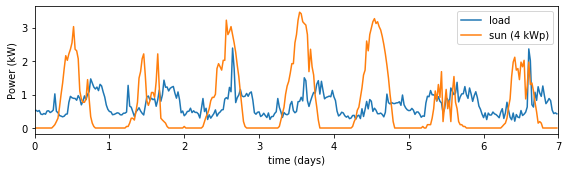

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp))
ax.legend()

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()

## Model of uncertainty: iid

### Building net load:

In [15]:
P_nl_train = P_load_train - P_sun_train

Fold the data day by day:

In [16]:
P_nl_train_daily = P_nl_train.values.reshape((-1,48))
P_nl_train_daily.shape

(30, 48)

resulting array can be indexed as `P_nl_train_daily[d,h]` with `d` in [0,29] and `h` in [0,47].

Vectorized slicing is also possible:

In [18]:
P_nl_train_daily[0,np.array([1,2,2])]

array([0.378, 0.342, 0.342])

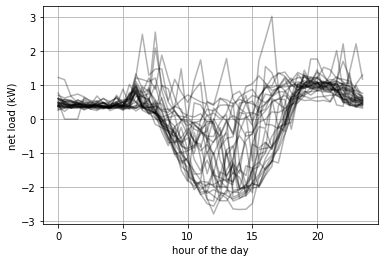

In [47]:
hod = np.arange(48)/2
plt.plot(hod, P_nl_train_daily.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

### Distribution at each hour of the day

In [111]:
#sampling scheme: P_nl_train_daily[d,h]

In [38]:
np.arange(10)[0:1]

array([0])

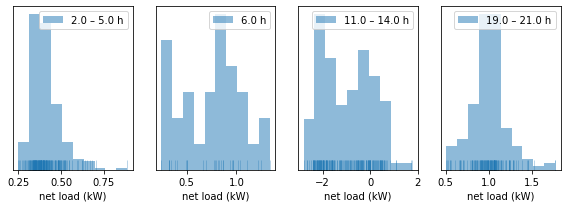

In [67]:
def plot_distrib(ax, hi1, hi2, color):
    a = P_nl_train_daily[:,hi1:hi2].flatten()
    ax.plot(a, np.zeros_like(a), '|', ms=20,
            alpha=0.3, color=color)
    h1 = hod[hi1]
    h2 = hod[hi2-1]
    label = f'{h1} – {h2} h' if h2>h1 else f'{h1} h'
    ax.hist(a, density=True, label=label,
            alpha=0.5, color=color)
    ax.legend()
    ax.set(
        xlabel='net load (kW)'
    )
    ax.set_yticks([])

fig, ax = plt.subplots(1,4, figsize=(8,3))

plot_distrib(ax[0], 4, 11, 'C0')
plot_distrib(ax[1], 12, 13, 'C0')
plot_distrib(ax[2], 22, 29, 'C0')
plot_distrib(ax[3], 38, 43, 'C0')
fig.tight_layout()

## SDP describtion

### Dynamics


Variables of the problem:

* 3 state variables: 
  * stored energy $E_{sto}$
  * net load $P_{nl}$
  * the hour of the day $hod$ 
* 1 control:
  * either $P_{sto}$ because $P_{gc}$  (grid - curtailment power) is deduced from energy conservation: $P_{gc} = P_{nl} + P_{sto}$
  * or $P_{gc}$ (grid - curtailment power) because $P_{sto}$ is deduced from energy conservation: $P_{sto} = P_{gc} - P_{nl}$
* 1 perturbation: $di$ ('day index') which influences $P_{nl}$ future value

In [ ]:
np.numpy

In [114]:
def dyn_sh_iid(E, P_nl, h, P_sto, di):
    '''state transition the solar home, with iid net load model
    
    returns (E(k+1), P_nl(k+1), h(k+1))
    '''
    # 1) Stored energy evolution:
    E_next = E + P_sto*dt
    # 2) next hour of the day
    int_h_next = np.round(2*(h + dt)).astype(int) % 48
    h_next = int_h_next/2
    # 3) next P_nl value: sample training day `w` at hour `h_next`
    P_nl_next = P_nl_train_daily[di,int_h_next]
    
    return (E_next, P_nl_next, h_next)

# Test:
dyn_sh_iid(5, 2, 23.5,
           1, 10)

(5.5, 0.77, 0.0)

Innov law: uniform integers (day indices in the training set)

In [115]:
di_law = stats.randint(low=0, high=30) # high is not included

### Set of admissible controls

In [116]:
def admissible_controls(E, P_nl, h):
    '''set of admissible control U(x_k) of an Energy storage
    control is P_sto
    ''' 
    # 1) Constraints on P_sto:
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))
    U1 = (P_neg, P_pos)
    return (U1, )

# Test:
admissible_controls(1, 0, 0)

((-2.0, 3.0),)

In [117]:
admissible_controls(7, 0, 0)

((-3.0, 2.0),)

### Cost function

cost is the grid cost

In [118]:
def cost(E, P_nl, h, P_sto, di):
    '''grid cost function of x,u,w
    '''
    # Grid power
    P_gc = P_nl + P_sto
    P_grid = np.where(P_gc > 0, P_gc, 0)
    
    # Grid price
    c_grid = np.where(h < 6, 0.10, 0.20)
    
    return c_grid*P_grid

cost(0,20,0,10,0)

3.0

In [119]:
cost(0,20,12,10,0)

6.0

### Collect all these function in one SysDescription object

In [120]:
sys_desc = SysDescription((3,1,1), name='Solar home iid')
sys_desc.dyn = dyn_sh_iid
sys_desc.control_box = admissible_controls
sys_desc.cost = cost
sys_desc.perturb_laws = [di_law]

sys_desc.print_summary()

Dynamical system "Solar home iid" description
* behavioral properties: stationnary, stochastic
* functions:
  - dynamics    : __main__.dyn_sh_iid
  - cost        : __main__.cost
  - control box : __main__.admissible_controls
* variables
  - state        : E, P_nl, h (dim 3)
  - control      : P_sto (dim 1)
  - perturbation : di (dim 1)


## Solve

### Create a DPSolver object

In [163]:
dpsolv = DPSolver(sys_desc)

# discretize the state space
n_E_sto = 21
n_P_nl = 31
n_h = 48
P_nl_max = 3
dpsolv.discretize_state(0, E_rated, n_E_sto,
                        -P_nl_max, P_nl_max, n_P_nl,
                        0, 23.5, n_h)
# discretize the perturbation
dpsolv.discretize_perturb(0,29,30) # already discrete

# control discretization step:
p_sto_step = 0.1 # kW
dpsolv.control_steps=(p_sto_step,)

dpsolv.print_summary()

SDP solver for system "Solar home iid"
* state space discretized on a 21x31x48 points grid
  - ΔE = 0.4
  - ΔP_nl = 0.2
  - Δh = 0.5
* perturbation discretized on a 30 points grid
  - Δdi = 1
* control discretization steps:
  - ΔP_sto = 0.1
    yields [31 to 61] possible values (54.1 on average)


In [164]:
dpsolv.perturb_grid

[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.])]

Fix perturb_grid to be `int`, otherwise indexing fails in vectorized policy evaluation

In [165]:
dpsolv.perturb_grid = [np.arange(30)]

In [166]:
dpsolv.perturb_grid

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])]

### Policy optimization with “Policy Iteration” algorithm

In [167]:
def P_sto_empirical(E, P_nl, h):
    '''empirical storage policy

    P_sto = - P_nl "whenever feasible"
    '''
    # Compute the contraints on P_sto
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))

    # "whenever feasible" control:
    P_sto = -P_nl
    if P_sto < P_neg:
        return P_neg
    elif P_sto > P_pos:
        return P_pos
    else:
        return P_sto
P_sto_emp_vect = np.vectorize(P_sto_empirical)

Tests:
* positive net load -> battery discharge
* negative net load -> battery charge

In [168]:
P_sto_emp_vect([0, 1, 4, 7, 8], 5, 0)

array([ 0., -2., -3., -3., -3.])

In [169]:
P_sto_emp_vect([0, 1, 4, 7, 8], -5, 0)

array([3., 3., 3., 2., 0.])

Evaluate this policy on the state grid:

In [170]:
state_grid = dpsolv.state_grid_full
E_sto_grid, P_nl_grid, h_grid  = state_grid

grid_shape = dpsolv._state_grid_shape
pol_ini = np.zeros(grid_shape + (1,))
# P_sto law:
pol_ini[...,0] = P_sto_emp_vect(*state_grid)
pol_ini.shape

(21, 31, 48, 1)

**Step 2**: Assess the number of value iterations required for the policy evalution to converge

policy evaluation run in 11.74 s     


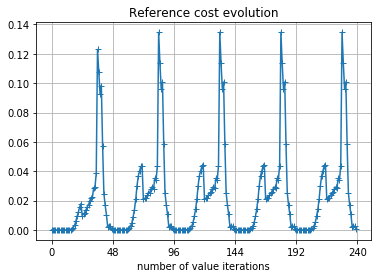

In [171]:
J, J_ref = dpsolv.eval_policy(pol_ini, 48*5, rel_dp=True, J_ref_full=True)
plt.plot(J_ref, '-+')
plt.title('Reference cost evolution');
plt.xlabel('number of value iterations');
plt.xticks(np.arange(6)*48)
plt.grid();

In [172]:
0.563/48

0.011729166666666666

Observation: convergence issue, related to the non noisy transition of the hod variable?

**Step 3:** Run Policy Iteration algorithm

In [173]:
# Number of policy iterations:
n_pol = 4

# Number of value iterations
#(inner loop used for policy evaluation)
n_val = 96

# run
J, pol = dpsolv.policy_iteration(pol_ini, 
                                 n_val, n_pol,
                                 rel_dp=True)

policy evaluation run in 5.01 s     
ref policy cost: 0.000580769
policy iteration 1/4
value iteration run in 7.94 s
policy evaluation run in 4.37 s     
ref policy cost: 9.36901e-05
policy iteration 2/4
value iteration run in 8.07 s
policy evaluation run in 4.05 s     
ref policy cost: 0.000155426
policy iteration 3/4
value iteration run in 7.92 s
policy evaluation run in 4.47 s     
ref policy cost: 0.000158229
policy iteration 4/4
value iteration run in 7.89 s
policy evaluation run in 4.12 s     
ref policy cost: 0.000158229


## Plot the policy

In [174]:
pol_sto = pol[..., 0]
pol_gc = P_nl_grid + pol_sto
pol_gc.shape

(21, 31, 48)

Obs: optimized policy is different than init pol. Sometimes Psto is bigger (precharging?), but never smaller

In [175]:
(pol_ini - pol).std()

0.4083195601514883

In [176]:
(pol_ini - pol).max(), (pol_ini - pol).min()

(1.3322676295501878e-15, -4.800000000000001)

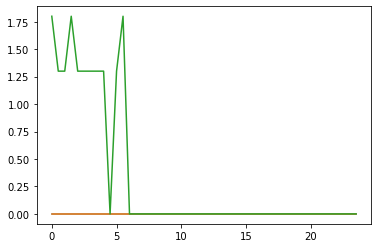

In [177]:
hod = np.arange(48)/2
plt.plot(hod,pol_gc[5,0,:])
plt.plot(hod,pol_gc[5,10,:])
plt.plot(hod,pol_gc[5,20,:]);

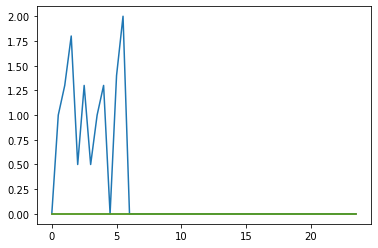

In [178]:
plt.plot(hod,pol_gc[0,10,:])
plt.plot(hod,pol_gc[5,10,:])
plt.plot(hod,pol_gc[8,10,:]);

In [179]:
im_opts = dict(interpolation='nearest', cmap = 'RdBu_r',
                   extent=(-P_nl_max, P_nl_max, 0, E_rated),
                   vmin=-P_rated, vmax=P_rated,
                   origin='lower', aspect='auto')
P_mis_label = 'Net load mismatch $P_{nl}$ (kW)'
E_sto_label = 'Storage energy $E_{sto}$ (kWh)'

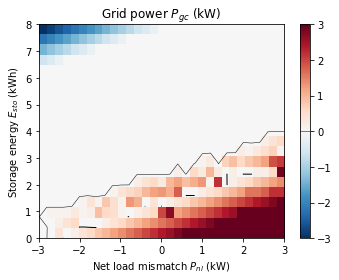

In [180]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Grid power $P_{gc}$ (kW)',
                          xlabel=P_mis_label, ylabel=E_sto_label)
im = ax.imshow(pol_gc[:,:,10],  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,10], E_sto_grid[:,:,10], pol_gc[:,:,10],
                [1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

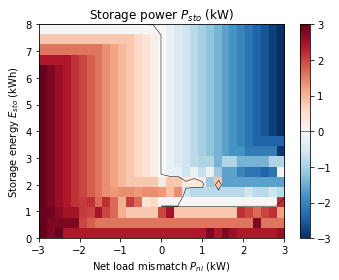

In [181]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Storage power $P_{sto}$ (kW)',
                          xlabel=P_mis_label, ylabel=E_sto_label)
im = ax.imshow(pol_sto[:,:,10],  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,10], E_sto_grid[:,:,10], pol_sto[:,:,10],
                [1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

--- 
## Simulation on test data


*TO BE DONE*

In [148]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun[k], P_load[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

In [149]:
print('E_load: {:6.2f} kWh/d (data)'.format(P_load.mean()*24))
print('E_sun:  {:6.2f} kWh/d (data)'.format(P_sun.mean()*24))
print('E_pv:   {:6.2f} kWh/d'.format(P_pv.mean()*24))
print('E_curt: {:6.2f} kWh/d'.format(P_curt.mean()*24))
print('E_grid: {:6.2f} kWh/d'.format(P_grid.mean()*24))

E_load:  16.90 kWh/d (data)
E_sun:   12.71 kWh/d (data)
E_pv:    12.40 kWh/d
E_curt:   0.31 kWh/d
E_grid:   3.78 kWh/d


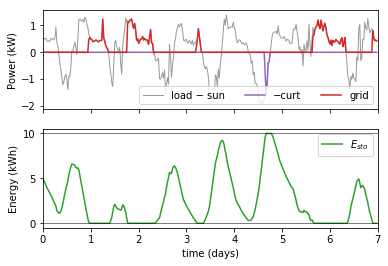

In [150]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, n//48)
);

### Write results

julia:

```
function write_results(fname, res)
    f = open(fname, "w")
    # header
    write(f, ",P_grid,P_curt,P_sto,E_sto\n")
    # optimization data
    data = zip(
        date, 
        res["P_grid"],
        res["P_curt"],
        res["P_sto"],
        res["E"][1:end-1])
    writecsv(f, data)
    close(f)
end

write_results("results/anticipative.csv", res_anticip)
write_results("results/fixed.csv", res_fixed)
```

In [ ]:
# TODO

## Sensitivity analysis against sizing

for a given load, effect of:

* P_pv rated
* E_rated